### Import the necessary libraries

In [80]:
# Path to user functions
import sys
sys.path.append("../Src/")
# display Python Version
from platform import python_version
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
from datetime import datetime
# user functions
import utilities as u
import statistical_testing as st
import plot_function as pf
import target_ecoding as te

# Initialize variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

Numpy Version: 2.3.1
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.10.0
Python Version: 3.13.5


### Load the dataset & Combine the train and test datasets

In [81]:
# Load the CSV files
print("Loading fraudTrain.csv...")
df_train = pd.read_csv("../Data/fraudTrain.csv")
print(f"Training data shape: {df_train.shape}")

print("\nLoading fraudTest.csv...")
df_test = pd.read_csv("../Data/fraudTest.csv")
print(f"Test data shape: {df_test.shape}")

Loading fraudTrain.csv...
Training data shape: (1296675, 23)

Loading fraudTest.csv...
Test data shape: (555719, 23)


In [82]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [83]:
# Check for NaNs
print("Checking for NaNs...")
print(df_train.isnull().sum())

Checking for NaNs...
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [84]:
# Check Data Types
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [85]:
df_train.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [86]:
df_train.is_fraud.value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

### Observations :
- From above we can observe that there is 23 features and 1,289,169 total rows
- 0: 1,289,169 & 1: 7,506
- This is highly imbalanced class data
    - We can try with the imbalabnce but we need to balance the dependent variable

### Data Wrangling

In [87]:
# # remove columns
# remove_cols = ['Unnamed: 0', 'street', 'trans_num', 'unix_time', ]
# # drop columns
# df.drop(columns=remove_cols, inplace=True, errors='ignore')

# Convert trans_date_trans_time to datetime
df_train['trans_date_trans_time'] = pd.to_datetime(df_train['trans_date_trans_time'])
# Convert dob to datetime
df_train['dob'] = pd.to_datetime(df_train['dob'])

# remove 'fraud_' prefix from the 'merchant' column
df_train['merchant'] = df_train['merchant'].str.replace('^fraud_', '', regex=True)

# display
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [88]:
# Convert trans_date_trans_time to datetime
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])
# Convert dob to datetime
df_test['dob'] = pd.to_datetime(df_test['dob'])

# remove 'fraud_' prefix from the 'merchant' column
df_test['merchant'] = df_test['merchant'].str.replace('^fraud_', '', regex=True)

# display
df_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


## Feature Engineering

In [89]:
# Current date
today = pd.Timestamp.today()

# determine month, day of the week
df_train['trans_qtr'] = df_train['trans_date_trans_time'].dt.quarter
df_train['trans_month'] = df_train['trans_date_trans_time'].dt.month
df_train['trans_day'] = df_train['trans_date_trans_time'].dt.day
df_train['trans_day_of_week'] = df_train['trans_date_trans_time'].dt.dayofweek
df_train['trans_hour'] = df_train['trans_date_trans_time'].dt.hour
df_train['trans_week_of_year'] = df_train['trans_date_trans_time'].dt.isocalendar().week
df_train['is_weekend'] = df_train['trans_day_of_week'].isin(['Saturday', 'Sunday'])

# For cyclical features like month, day_of_week, hour_of_day, consider sine and cosine transformations to preserve their cyclical nature 
# (e.g., 23:00 is closer to 00:00 than to 12:00).
# For example, you can create sine and cosine transformations for the hour of the day:
df_train['trans_hour_sin'] = np.sin(2 * np.pi * df_train['trans_hour'].astype(int) / 24)
df_train['trans_hour_cos'] = np.cos(2 * np.pi * df_train['trans_hour'].astype(int) / 24)

df_train['trans_month_sin'] = np.sin(2 * np.pi * df_train['trans_month'].astype(int) / 12)
df_train['trans_month_cos'] = np.cos(2 * np.pi * df_train['trans_month'].astype(int) / 12)

df_train['trans_day_of_week_sin'] = np.sin(2 * np.pi * df_train['trans_day_of_week'].astype(int) / 7)
df_train['trans_day_of_week_cos'] = np.cos(2 * np.pi * df_train['trans_day_of_week'].astype(int) / 7)

# Calculate age
df_train['age'] = df_train['dob'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

#
df_train .head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_hour,trans_week_of_year,is_weekend,trans_hour_sin,trans_hour_cos,trans_month_sin,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,37
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,47
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,63
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,58
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,39


In [90]:
# determine month, day of the week
df_test['trans_qtr'] = df_test['trans_date_trans_time'].dt.quarter
df_test['trans_month'] = df_test['trans_date_trans_time'].dt.month
df_test['trans_day'] = df_test['trans_date_trans_time'].dt.day
df_test['trans_day_of_week'] = df_test['trans_date_trans_time'].dt.dayofweek
df_test['trans_hour'] = df_test['trans_date_trans_time'].dt.hour
df_test['trans_week_of_year'] = df_test['trans_date_trans_time'].dt.isocalendar().week
df_test['is_weekend'] = df_test['trans_day_of_week'].isin(['Saturday', 'Sunday'])

# For cyclical features like month, day_of_week, hour_of_day, consider sine and cosine transformations to preserve their cyclical nature 
# (e.g., 23:00 is closer to 00:00 than to 12:00).
# For example, you can create sine and cosine transformations for the hour of the day:
df_test['trans_hour_sin'] = np.sin(2 * np.pi * df_test['trans_hour'].astype(int) / 24)
df_test['trans_hour_cos'] = np.cos(2 * np.pi * df_test['trans_hour'].astype(int) / 24)

df_test['trans_month_sin'] = np.sin(2 * np.pi * df_test['trans_month'].astype(int) / 12)
df_test['trans_month_cos'] = np.cos(2 * np.pi * df_test['trans_month'].astype(int) / 12)

df_test['trans_day_of_week_sin'] = np.sin(2 * np.pi * df_test['trans_day_of_week'].astype(int) / 7)
df_test['trans_day_of_week_cos'] = np.cos(2 * np.pi * df_test['trans_day_of_week'].astype(int) / 7)

# Calculate age
df_test['age'] = df_test['dob'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

#
df_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_hour,trans_week_of_year,is_weekend,trans_hour_sin,trans_hour_cos,trans_month_sin,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age
0,0,2020-06-21 12:14:25,2291163933867244,Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,12,25,False,1.224647e-16,-1.0,1.224647e-16,-1.0,-0.781831,0.62349,57
1,1,2020-06-21 12:14:33,3573030041201292,Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,12,25,False,1.224647e-16,-1.0,1.224647e-16,-1.0,-0.781831,0.62349,35
2,2,2020-06-21 12:14:53,3598215285024754,"Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,12,25,False,1.224647e-16,-1.0,1.224647e-16,-1.0,-0.781831,0.62349,54
3,3,2020-06-21 12:15:15,3591919803438423,Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,12,25,False,1.224647e-16,-1.0,1.224647e-16,-1.0,-0.781831,0.62349,37
4,4,2020-06-21 12:15:17,3526826139003047,Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,12,25,False,1.224647e-16,-1.0,1.224647e-16,-1.0,-0.781831,0.62349,70


### New Features

In [91]:
# Create a mapping for industry identifier
mii_to_industry = {
    '1': 'Airlines',
    '2': 'Airlines & Financial',
    '3': 'Travel & Entertainment (e.g., American Express, Diners Club)',
    '4': 'Banking & Financial (e.g., Visa)',
    '5': 'Banking & Financial (e.g., Mastercard)',
    '6': 'Merchandising & Banking (e.g., Discover)',
    '7': 'Petroleum',
    '8': 'Healthcare & Telecommunications',
    '9': 'National Assignment / Other'
}

# apply lamda function to map first digit of cc_num to industry
df_train['industry'] = df_train['cc_num'].apply(lambda x: u.map_first_digit_to_value(x, mapping_dict=mii_to_industry))

# determe credit card network
df_train['cc_network'] = df_train['cc_num'].apply(lambda x: u.get_credit_card_network(str(x)))

# determine store distance
df_train['store_distance'] = df_train.apply(
    lambda x: u.haversine_distance_calc(x['lat'], x['long'], x['merch_lat'], x['merch_long']),
    axis=1
)

# convert amount to log scale
df_train['amt_log'] = np.log1p(df_train['amt'])  # Using log1p
df_train['city_pop_log'] = np.log1p(df_train['city_pop'])  # Using log1p

# Convert 'is_fraud' to a numeric type (int or float)
df_train['is_fraud'] = df_train['is_fraud'].astype(int)  # or float, depending on your data


# Define Non-ordered categorical columns
cat_cols = ['merchant', 'category', 'gender', 'city', 'state', 'zip', 'job', 'trans_qtr', 'trans_month', 'trans_day',  
            'trans_day_of_week', 'trans_hour', 'trans_week_of_year', 'industry', 'cc_network']
df_train[cat_cols] = df_train[cat_cols].astype('category')


# Display the first few rows of the updated DataFrame
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_month_sin,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age,industry,cc_network,store_distance,amt_log,city_pop_log
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0.5,0.866025,0.781831,0.62349,37,Airlines & Financial,Mastercard,48.838332,1.786747,8.159375
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,0.5,0.866025,0.781831,0.62349,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001,4.684259,5.010635
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,0.5,0.866025,0.781831,0.62349,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235,5.398660,8.332068
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,0.5,0.866025,0.781831,0.62349,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671,3.828641,7.570443
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,0.5,0.866025,0.781831,0.62349,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592,3.760269,4.605170


In [92]:
# apply lamda function to map first digit of cc_num to industry
df_test['industry'] = df_test['cc_num'].apply(lambda x: u.map_first_digit_to_value(x, mapping_dict=mii_to_industry))

# determe credit card network
df_test['cc_network'] = df_test['cc_num'].apply(lambda x: u.get_credit_card_network(str(x)))

# determine store distance
df_test['store_distance'] = df_test.apply(
    lambda x: u.haversine_distance_calc(x['lat'], x['long'], x['merch_lat'], x['merch_long']),
    axis=1
)

# convert amount to log scale
df_test['amt_log'] = np.log1p(df_test['amt'])  # Using log1p
df_test['city_pop_log'] = np.log1p(df_test['city_pop'])  # Using log1p

# Convert 'is_fraud' to a numeric type (int or float)
df_test['is_fraud'] = df_test['is_fraud'].astype(int)  # or float, depending on your data


# Define Non-ordered categorical columns
df_test[cat_cols] = df_test[cat_cols].astype('category')


# Display the first few rows of the updated DataFrame
df_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_month_sin,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age,industry,cc_network,store_distance,amt_log,city_pop_log
0,0,2020-06-21 12:14:25,2291163933867244,Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,1.224647e-16,-1.0,-0.781831,0.62349,57,Airlines & Financial,Mastercard,15.261806,1.350667,12.717392
1,1,2020-06-21 12:14:33,3573030041201292,Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,1.224647e-16,-1.0,-0.781831,0.62349,35,"Travel & Entertainment (e.g., American Express...",JCB,65.197519,3.428813,5.713733
2,2,2020-06-21 12:14:53,3598215285024754,"Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,1.224647e-16,-1.0,-0.781831,0.62349,54,"Travel & Entertainment (e.g., American Express...",Unknown,36.710709,3.744314,10.448628
3,3,2020-06-21 12:15:15,3591919803438423,Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,1.224647e-16,-1.0,-0.781831,0.62349,37,"Travel & Entertainment (e.g., American Express...",Unknown,17.211115,4.111693,10.910861
4,4,2020-06-21 12:15:17,3526826139003047,Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,1.224647e-16,-1.0,-0.781831,0.62349,70,"Travel & Entertainment (e.g., American Express...",Unknown,64.830918,1.432701,7.027315


In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 42 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  category      
 4   category               1296675 non-null  category      
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   gender                 1296675 non-null  category      
 9   street                 1296675 non-null  object        
 10  city                   1296675 non-null  category      
 11  state                  1296675 non-null  category      
 12  zip                    12966

## Visualization

--- Chi-Square Test between 'trans_hour' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud    0 (count)  1 (count)  0 (%)  1 (%)
trans_hour                                    
0               41867        635   3.25   8.46
1               42211        658   3.27   8.77
2               42031        625   3.26   8.33
3               42160        609   3.27   8.11
4               41817         46   3.24   0.61
5               42111         60   3.27   0.80
6               42260         40   3.28   0.53
7               42147         56   3.27   0.75
8               42456         49   3.29   0.65
9               42138         47   3.27   0.63
10              42231         40   3.28   0.53
11              42040         42   3.26   0.56
12              65190         67   5.06   0.89
13              65234         80   5.06   1.07
14              64799         86   5.03   1.15
15              65312         79   5.07   1.05
16              65650         76   5.09   1.01
17              6

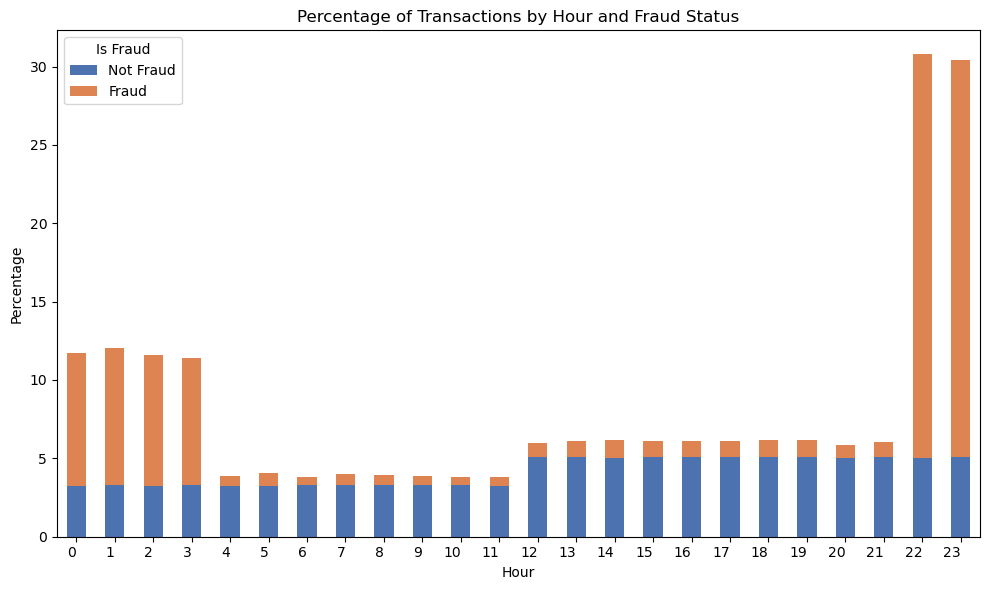

In [94]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'trans_hour', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Hour')
plt.title('Percentage of Transactions by Hour and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


#### Summary
- The Chi-Square test provides strong statistical evidence to conclude that there is a significant association between the hour of a transaction and whether or not it is fraudulent.
- Fraudulent transactions are disproportionately higher during late-night and early-morning hours (00-03 and especially 22-23). For instance, 25.71% of all fraudulent transactions occur at 22:00, and 25.30% at 23:00, even though these hours account for only about 5% of non-fraudulent transactions.
- Conversely, daytime hours (roughly 04:00 to 21:00) generally see a lower percentage of fraudulent transactions relative to non-fraudulent ones.

--- Chi-Square Test between 'trans_day_of_week' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud           0 (count)  1 (count)  0 (%)  1 (%)
trans_day_of_week                                    
0                     253100       1182  19.63  15.75
1                     159292        935  12.36  12.46
2                     130214        859  10.10  11.44
3                     146277       1008  11.35  13.43
4                     151193       1079  11.73  14.38
5                     199730       1227  15.49  16.35
6                     249363       1216  19.34  16.20

Expected Frequencies:
is_fraud                       0            1
trans_day_of_week                            
0                  252810.050057  1471.949943
1                  159299.501697   927.498303
2                  130314.264050   758.735950
3                  146432.418428   852.581572
4                  151390.550422   881.449578
5                  199793.729912  1163.270088
6                  249128.

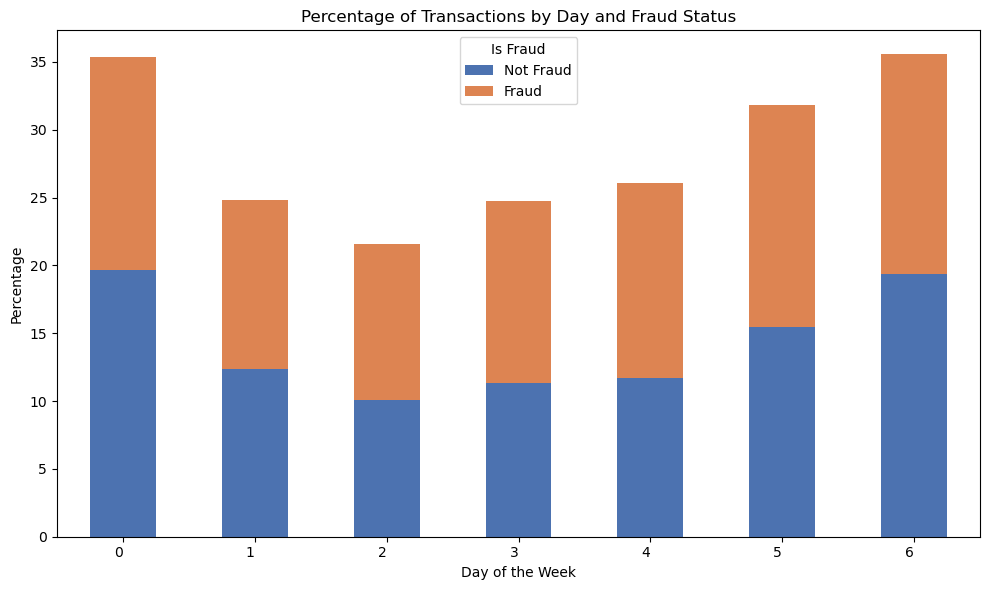

In [95]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'trans_day_of_week', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Day of the Week')
plt.title('Percentage of Transactions by Day and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### Summary

- There is a statistically significant relationship between the day of the week and whether a transaction is fraudulent.
- This statistical significance supports the observation that fraudulent activity tends to be more concentrated toward the end of the week.
    - Thursday and Friday have a higher share of fraudulent transactions (13.65% and 14.26% respectively) compared to their share of non-fraudulent transactions (11.15% and 11.60%). This suggests an elevated risk on these days.
    - Monday and Sunday show a lower share of fraudulent transactions (15.38% and 16.47%) relative to their non-fraudulent volume (19.97% and 18.56%), indicating a comparatively lower risk.
    - Saturday fraud is roughly proportionate to its transaction volume, with its share of fraudulent transactions (15.47%) being very close to its share of non-fraudulent transactions (14.20%).
- Fraudulent activity tends to be more concentrated toward the end of the week, particularly on Thursday and Friday. This could reflect the behavioral patterns of fraudsters, who may exploit the end-of-week rush or reduced oversight. 

--- Chi-Square Test between 'trans_month' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud     0 (count)  1 (count)  0 (%)  1 (%)
trans_month                                    
1               103878        849   8.06  11.31
2                96804        853   7.51  11.36
3               142851        938  11.08  12.50
4               134292        678  10.42   9.03
5               145940        935  11.32  12.46
6               143123        688  11.10   9.17
7                86265        331   6.69   4.41
8                86977        382   6.75   5.09
9                70234        418   5.45   5.57
10               68304        454   5.30   6.05
11               70033        388   5.43   5.17
12              140468        592  10.90   7.89

Expected Frequencies:
is_fraud                 0           1
trans_month                           
1            104120.771869  606.228131
2             97091.697637  565.302363
3            142956.655554  832.344446
4            134188

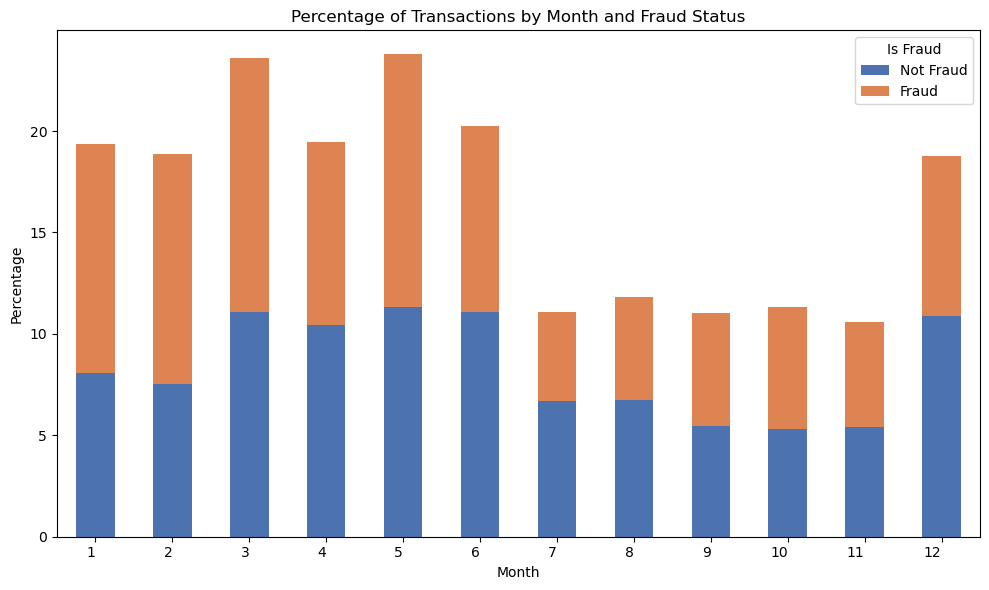

In [96]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'trans_month', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Month')
plt.title('Percentage of Transactions by Month and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides strong statistical evidence to conclude that there is a significant association between the month of a transaction and whether or not it is fraudulent.
- Some months, like January, February, March, and May, appear to have a relatively higher proportion of fraudulent transactions compared to their overall transaction volume.
- Conversely, months like December, July, April, and November, show a comparatively lower proportion of fraud relative to their total transaction activity. December is particularly notable for its high volume of non-fraudulent transactions but a relatively lower percentage of fraud.
- This finding suggests that the month of the year is a relevant factor in understanding and potentially predicting fraudulent activity. Further investigation into seasonal patterns, holidays, or specific events occurring in these months could provide deeper insights into the underlying reasons for these variations.

--- Chi-Square Test between 'category' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud        0 (count)  1 (count)  0 (%)  1 (%)
category                                          
entertainment       93781        233   7.27   3.10
food_dining         91310        151   7.08   2.01
gas_transport      131041        618  10.16   8.23
grocery_net         45318        134   3.52   1.79
grocery_pos        121895       1743   9.46  23.22
health_fitness      85746        133   6.65   1.77
home               122917        198   9.53   2.64
kids_pets          112796        239   8.75   3.18
misc_net            62372        915   4.84  12.19
misc_pos            79405        250   6.16   3.33
personal_care       90538        220   7.02   2.93
shopping_net        95830       1713   7.43  22.82
shopping_pos       115829        843   8.98  11.23
travel              40391        116   3.13   1.55

Expected Frequencies:
is_fraud                    0           1
category                       

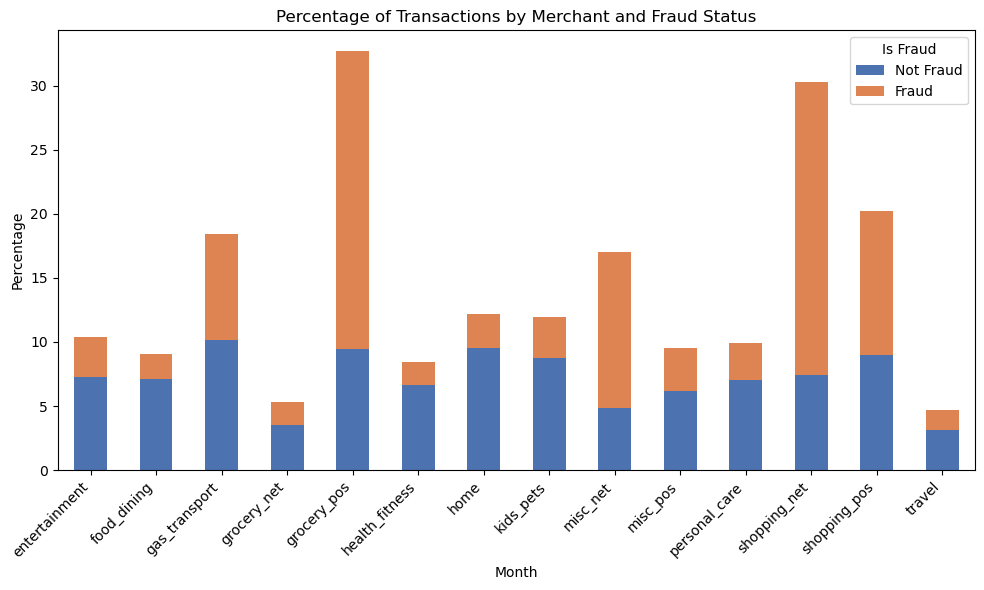

In [97]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'category', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Month')
plt.title('Percentage of Transactions by Merchant and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Summary
- This Chi-Square test definitively shows strong statistical evidence that there is a significant association between the transaction 'category' and whether or not a transaction is fraudulent.
- Fraud Risk by Category: Certain transaction categories, most notably 'grocery_pos', 'shopping_net', and 'misc_net', exhibit a significantly higher propensity for fraud compared to their overall transaction volume. These are critical areas for fraud detection and prevention efforts.
- Lower Risk Categories: Conversely, categories like 'entertainment', 'food_dining', 'health_fitness', and 'home' appear to have a relatively lower fraud risk.
- This information is highly valuable for building fraud detection models, implementing targeted fraud prevention rules, or designing specific monitoring for high-risk categories.
    - High-Risk Categories:
        - grocery_pos and shopping_net are top fraud targets, each accounting for 23% of fraud but much lower share of total transactions.
        - misc_net also stands out with 12% of fraud from just 5% of transactions.
    - Low-Risk Categories:
        - Categories like entertainment, food_dining, health_fitness, and travel show significantly less fraud than expected.

--- Chi-Square Test between 'industry' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud                                                      0 (count)  1 (count)  0 (%)  1 (%)
industry                                                                                        
Airlines                                                          39639        254   3.07   3.38
Airlines & Financial                                             127519        699   9.89   9.31
Banking & Financial (e.g., Mastercard)                            61292        419   4.75   5.58
Banking & Financial (e.g., Visa)                                 416384       2441  32.30  32.52
Merchandising & Banking (e.g., Discover)                         160879       1013  12.48  13.50
Travel & Entertainment (e.g., American Express, Diners Club)     483456       2680  37.50  35.70

Expected Frequencies:
is_fraud                                                        0            1
industry                          

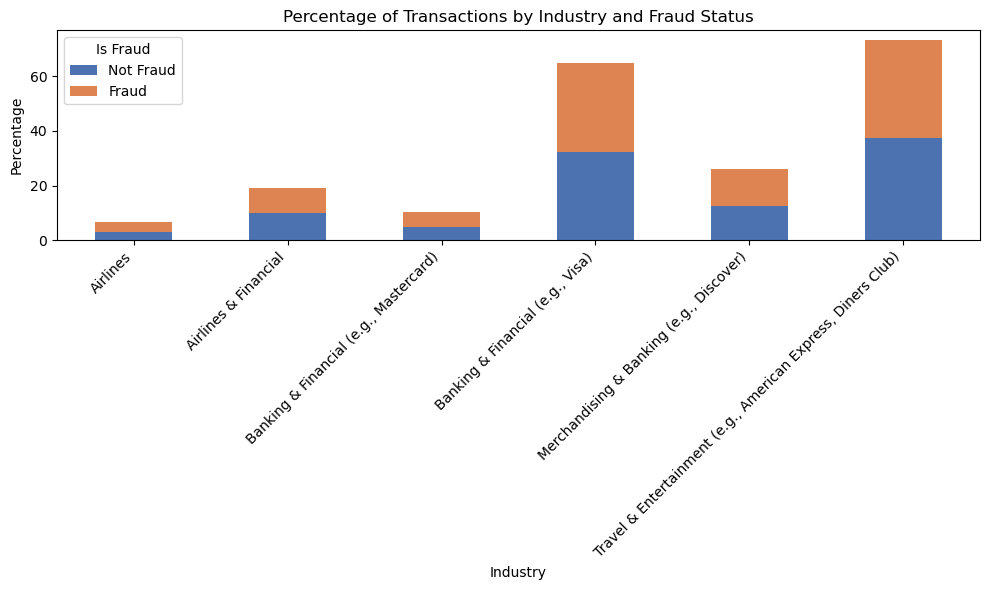

In [98]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'industry', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Industry')
plt.title('Percentage of Transactions by Industry and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides statistically significant evidence that there is an association between the 'industry' and whether a transaction is fraudulent.
- While some industries show very proportional fraud rates (like Visa and Amex/Diners Club due to their large overall volumes), others exhibit slight but statistically significant deviations. Specifically:
    - Airlines and Banking & Financial (e.g., Mastercard) show a slightly higher percentage of fraudulent transactions compared to their overall transaction volume, suggesting a marginally elevated risk.
    - Airlines & Financial shows a slightly lower percentage of fraudulent transactions.
    - Although the proportional differences might seem small at first glance, the large number of observations (counts) gives the test enough power to detect these subtle but statistically significant variations. This means the distribution of fraud is not perfectly uniform across these industry types.

--- Chi-Square Test between 'cc_network' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud          0 (count)  1 (count)  0 (%)  1 (%)
cc_network                                          
American Express     123208        626   9.56   8.34
Diners Club          125382        603   9.73   8.03
Discover             104786        650   8.13   8.66
JCB                  145994        944  11.32  12.58
Maestro               96959        620   7.52   8.26
Mastercard            95943        622   7.44   8.29
Unknown              180513       1000  14.00  13.32
Visa                 416384       2441  32.30  32.52

Expected Frequencies:
is_fraud                      0            1
cc_network                                  
American Express  123117.168100   716.831900
Diners Club       125255.716710   729.283290
Discover          104825.667715   610.332285
JCB               146087.427090   850.572910
Maestro            97014.149151   564.850849
Mastercard         96006.018844   558.9811

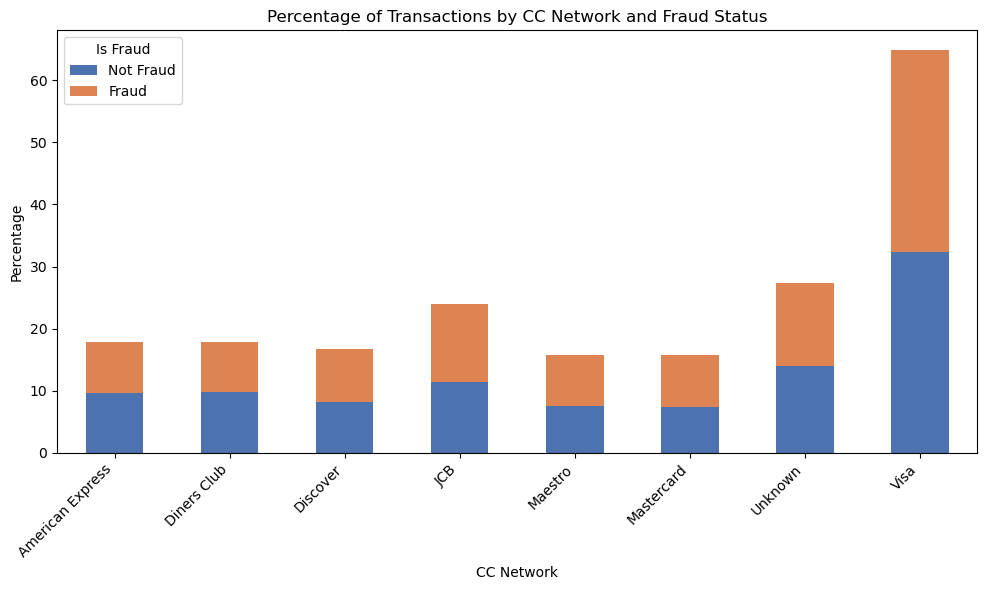

In [99]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'cc_network', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('CC Network')
plt.title('Percentage of Transactions by CC Network and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides strong statistical evidence that there is a significant association between the credit card network used for a transaction and whether or not that transaction is fraudulent.
- While some networks like Visa and Discover show very proportional fraud rates (meaning their share of fraud is similar to their share of overall transactions), the statistical significance arises from the deviations seen in other networks:
- JCB and Maestro appear to be slightly overrepresented in fraudulent transactions (meaning a higher percentage of total fraud involves these networks than their percentage of total non-fraudulent transactions).
- Diners Club appears to be slightly underrepresented in fraudulent transactions.
- These differences, although sometimes appearing small in percentage points, are consistently strong enough across the large dataset to be considered statistically significant, meaning they are unlikely due to random chance. This indicates that the credit card network can be a relevant factor in fraud analysis and detection.

--- Chi-Square Test between 'gender' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud  0 (count)  1 (count)  0 (%)  1 (%)
gender                                      
F            706128       3735  54.77  49.76
M            583041       3771  45.23  50.24

Expected Frequencies:
is_fraud              0            1
gender                              
F         705753.850307  4109.149693
M         583415.149693  3396.850307

Chi-square Statistic = 75.5146
Degrees of Freedom   = 1
P-value              = 0.0000
➡️ Statistically significant association (Reject Null Hypothesis)


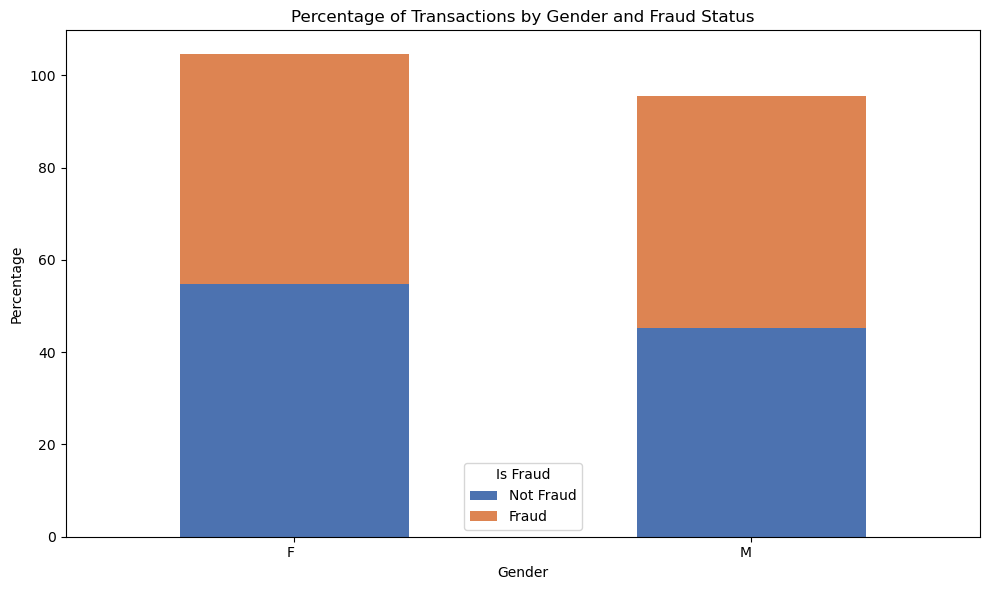

In [100]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'gender', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Gender')
plt.title('Percentage of Transactions by Gender and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides strong statistical evidence that there is a significant association between 'gender' and whether or not a transaction is fraudulent.
- Although the percentage differences might seem small (e.g., 45.23% vs 54.77% for females), the extremely large sample size allows even these subtle variations to be statistically significant.
- While females account for a larger share of overall transactions, they are less likely to be involved in fraudulent transactions when compared to their overall transaction volume.
- Conversely, males account for a smaller share of overall transactions, but are more likely to be involved in fraudulent transactions when compared to their overall transaction volume.
- This doesn't mean that one gender is inherently "more fraudulent" than the other, but rather that there's a detectable pattern in how fraud manifests across gender categories within this dataset. This insight could be used to inform fraud detection models or risk assessment strategies, as gender appears to be a statistically relevant feature.

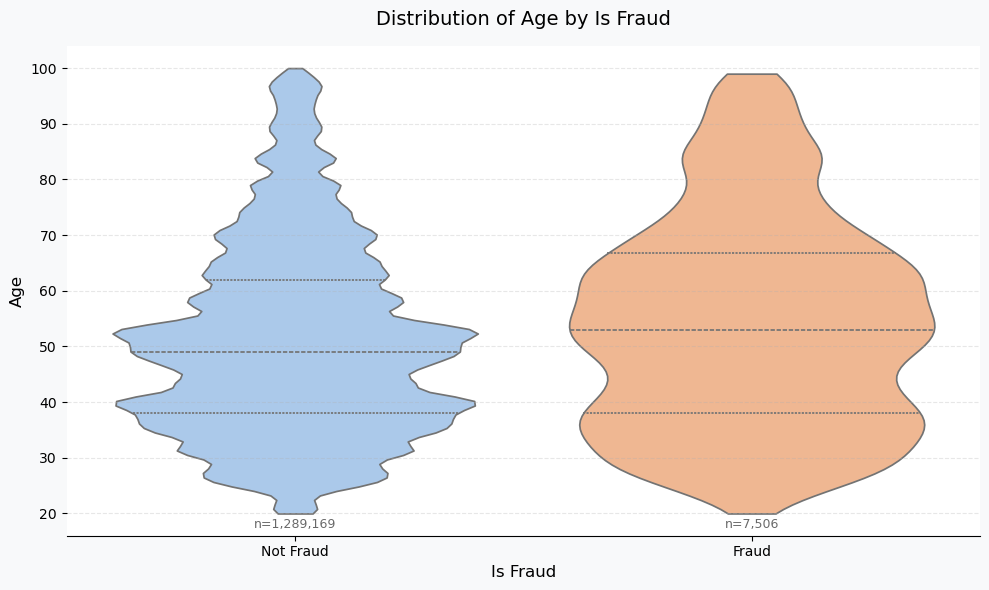

In [101]:
pf.plot_violin_by_binary_category(df_train, 'is_fraud', 'age')

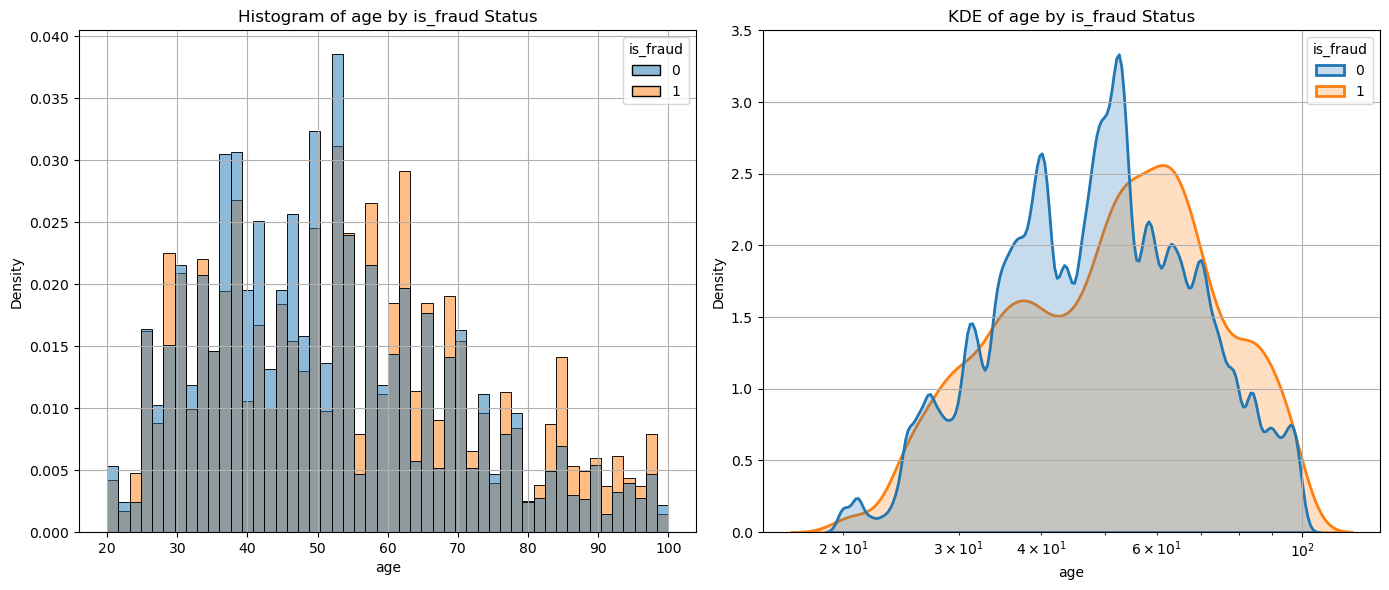

In [102]:
pf.plot_distribution(df_train, 'age', 'is_fraud', log_scale=False, bins=50)

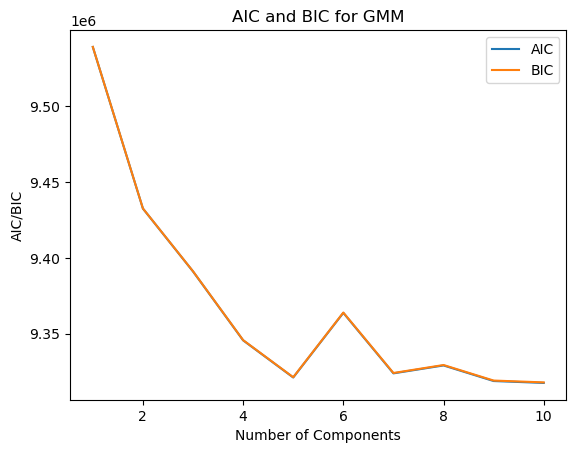

In [103]:
# Determine optimal bins using Gaussian Mixture Model
st.gaussian_mixture_binning(df_train, ['age'], RANDOM_STATE)

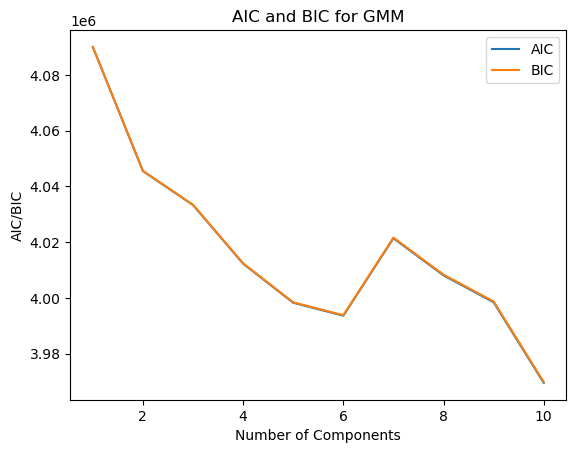

In [104]:
# Determine optimal bins using Gaussian Mixture Model
st.gaussian_mixture_binning(df_test, ['age'], RANDOM_STATE)

In [105]:
# Descretize age into 6 bins based on GMM results
df_train = st.discretization(df_train, 'age', 'age_group', 5, 'Age Group')

df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age,industry,cc_network,store_distance,amt_log,city_pop_log,age_group
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0.866025,0.781831,0.62349,37,Airlines & Financial,Mastercard,48.838332,1.786747,8.159375,Age Group(36-44)
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,0.866025,0.781831,0.62349,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001,4.684259,5.010635,Age Group(44-53)
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,0.866025,0.781831,0.62349,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235,5.398660,8.332068,Age Group(53-66)
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,0.866025,0.781831,0.62349,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671,3.828641,7.570443,Age Group(53-66)
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,0.866025,0.781831,0.62349,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592,3.760269,4.605170,Age Group(36-44)


In [106]:
# Descretize age into 6 bins based on GMM results
df_test = st.discretization(df_test, 'age', 'age_group', 5, 'Age Group')

df_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age,industry,cc_network,store_distance,amt_log,city_pop_log,age_group
0,0,2020-06-21 12:14:25,2291163933867244,Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,-1.0,-0.781831,0.62349,57,Airlines & Financial,Mastercard,15.261806,1.350667,12.717392,Age Group(53-66)
1,1,2020-06-21 12:14:33,3573030041201292,Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,-1.0,-0.781831,0.62349,35,"Travel & Entertainment (e.g., American Express...",JCB,65.197519,3.428813,5.713733,Age Group(20-36)
2,2,2020-06-21 12:14:53,3598215285024754,"Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,-1.0,-0.781831,0.62349,54,"Travel & Entertainment (e.g., American Express...",Unknown,36.710709,3.744314,10.448628,Age Group(53-66)
3,3,2020-06-21 12:15:15,3591919803438423,Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,-1.0,-0.781831,0.62349,37,"Travel & Entertainment (e.g., American Express...",Unknown,17.211115,4.111693,10.910861,Age Group(36-44)
4,4,2020-06-21 12:15:17,3526826139003047,Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,-1.0,-0.781831,0.62349,70,"Travel & Entertainment (e.g., American Express...",Unknown,64.830918,1.432701,7.027315,Age Group(66-100)


--- Chi-Square Test between 'age_group' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud           0 (count)  1 (count)  0 (%)  1 (%)
age_group                                            
Age Group(20-36)      279339       1615  21.67  21.52
Age Group(36-44)      240005       1041  18.62  13.87
Age Group(44-53)      274773       1204  21.31  16.04
Age Group(53-66)      246343       1769  19.11  23.57
Age Group(66-100)     248709       1877  19.29  25.01

Expected Frequencies:
is_fraud                       0            1
age_group                                    
Age Group(20-36)   279327.655138  1626.344862
Age Group(36-44)   239650.668652  1395.331348
Age Group(44-53)   274379.465258  1597.534742
Age Group(53-66)   246675.766039  1436.233961
Age Group(66-100)  249135.444914  1450.555086

Chi-square Statistic = 391.7379
Degrees of Freedom   = 4
P-value              = 0.0000
➡️ Statistically significant association (Reject Null Hypothesis)


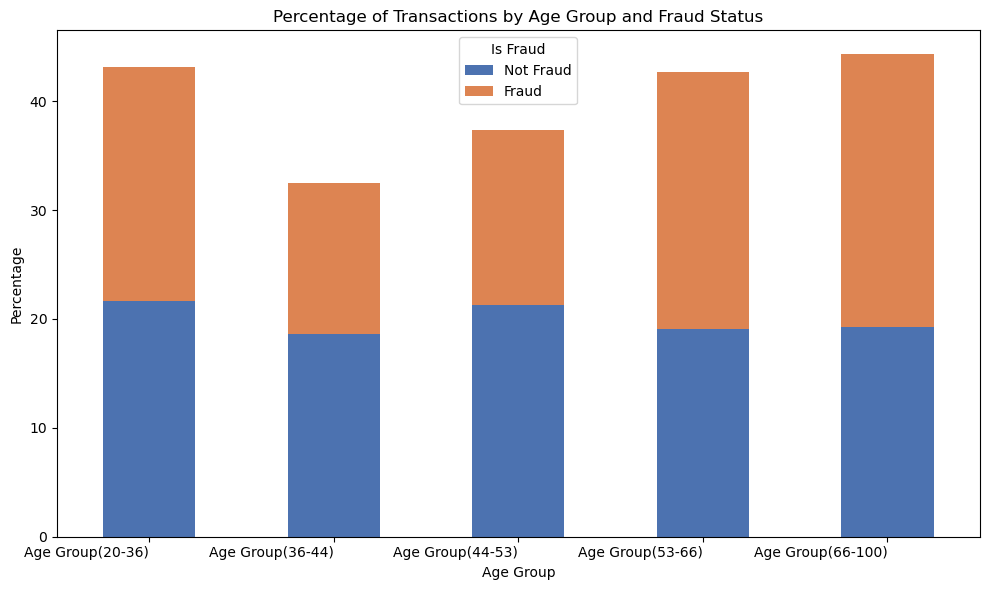

In [107]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df_train, 'age_group', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Age Group')
plt.title('Percentage of Transactions by Age Group and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- Based on the data, age does appear to have a significant effect on the likelihood of a transaction being fraudulent.
- The distribution of fraudulent versus non-fraudulent transactions across age group with strong evidence of concentration in fraud risk associated with specific age group.
- Contingency Table Overview after Discretization
    - Age Groups (20-36, 36-44, 44-53, 53-66, 66-100)
- Expected vs. Observed
    - There are visible differences between observed and expected counts, especially in the fraud.
- Conclusion
    - P-value < 0.05: Strong evidence to reject the null hypothesis. There is a statistically significant association between age group and fraud occurrence in the data. likelihood of fraud differs by age group.
    - Younger (20-36) and older (53-100) age groups have slightly higher fraud percentages.
    - Middle age groups (36-44, 44-53) show lower fraud rates.
    - There is a significant relationship between age group and fraud status. Age appears to influence the likelihood of fraud, so age-specific monitoring or interventions could be considered.
- Why Might Younger and Older Age Groups Be More Prone to Fraud?
    - Younger Age Groups (20–36) Younger adults may have less experience recognizing scams or fraudulent activities and tyhey tend to use more online platforms, increasing exposure to digital fraud. Younger people may be more likely to take risks or try new financial products/services without thorough vetting. They may not have developed strong habits for verifying information or protecting personal data.
    - Older Age Groups (53–100) Possible cognitive decline or slower reaction times can make it harder to spot scams and older adults may be more trusting, especially of authority figures or official-looking communications. Social isolation can make older adults more susceptible to scams that exploit loneliness inclduing less familiarity with digital technology can make it harder to recognize phishing or online fraud.

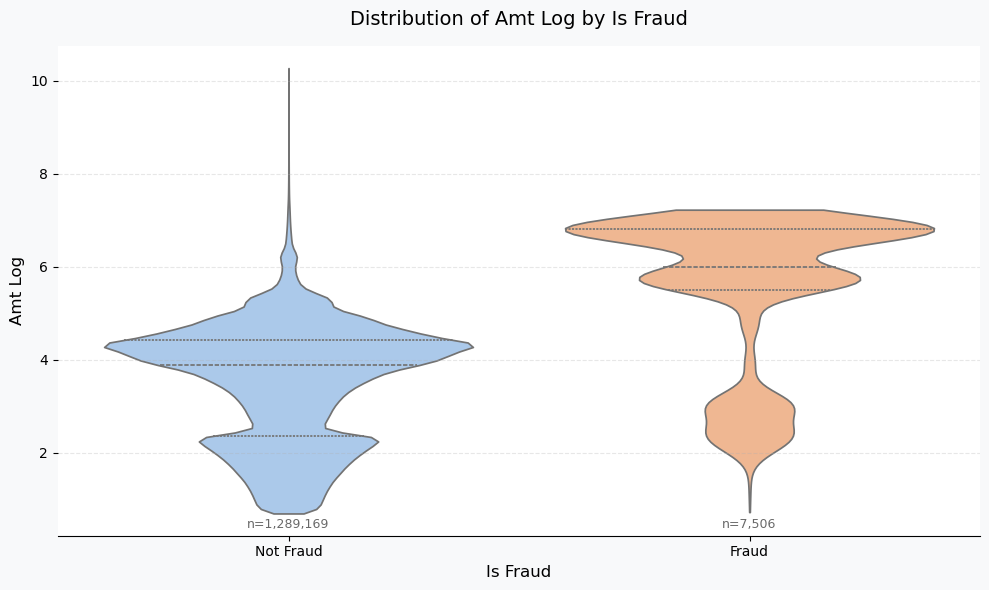

In [108]:
pf.plot_violin_by_binary_category(df_train, 'is_fraud', 'amt_log')

Plot saved to ../Image/Amount_Distribution_Log.png with 600 DPI.


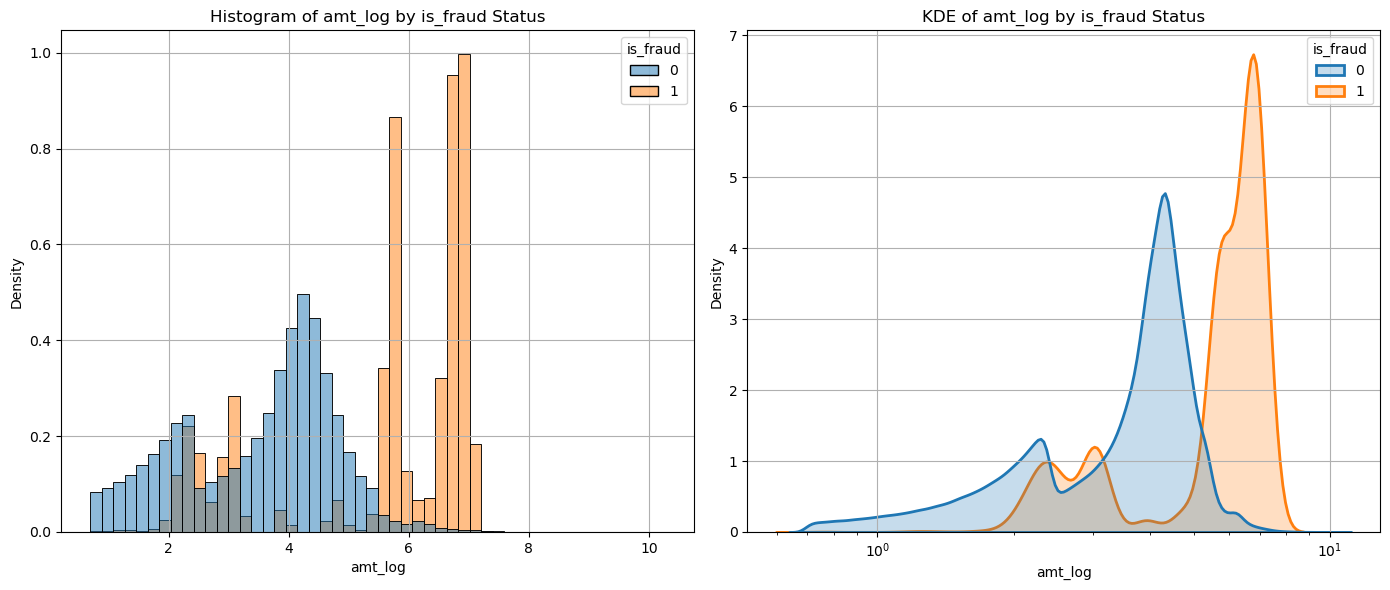

In [109]:
pf.plot_distribution(df_train, 'amt_log', 'is_fraud', save_path="../Image/Amount_Distribution_Log.png", dpi=600, log_scale=False, bins=50)

#### Summary
- Transaction Amount and Fraud Analysis
    - Fraudulent transactions occur across a broad spectrum of transaction amounts, indicating that fraud is not limited to high-dollar or low-dollar amounts exclusively. However, there is a clear trend of increasing fraud density as transaction amounts rise.
- Implications:
    - It may be worthwhile to establish tiered fraud monitoring thresholds, allocating more scrutiny to high-value transactions during peak fraud hours (e.g., 22:00–03:00).
    - Further analysis could examine interaction effects between transaction amount and other features such as merchant type, category type, or card network to uncover multi-dimensional fraud patterns.

Plot saved to ../Image/Pop_Distribution_log.png with 600 DPI.


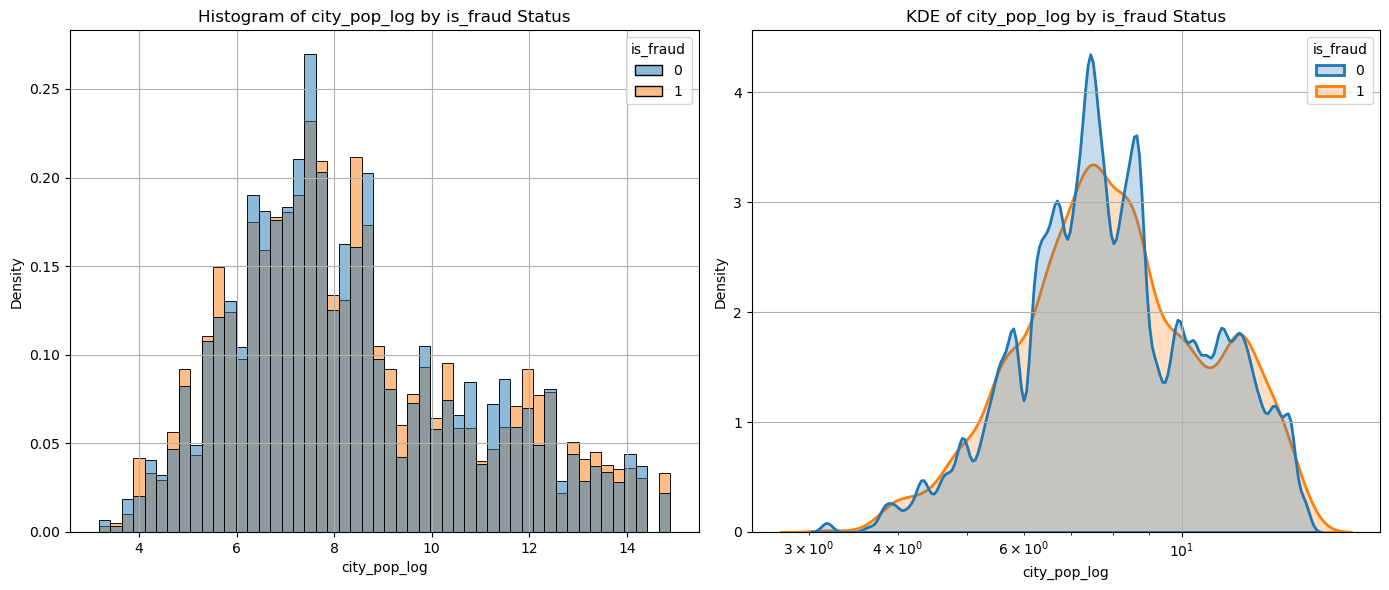

In [110]:
pf.plot_distribution(df_train, 'city_pop_log', 'is_fraud', save_path="../Image/Pop_Distribution_log.png", dpi=600, log_scale=False, bins=50)

In [111]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Filter for fraudulent transactions
fraud_df = df_train[df_train['is_fraud'] == 1].copy() # Use .copy() to avoid SettingWithCopyWarning

# One-Way ANOVA using OLS (similar to scipy.stats.f_oneway but more detailed output)
# The formula 'C(merchant)' tells statsmodels that 'merchant' is a categorical variable
model = ols('amt ~ C(category)', data=fraud_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) # typ=2 or typ=3 for different types of sum of squares

print("ANOVA Table for Fraudulent Transaction Amounts by Merchant Category (using statsmodels):")
print(anova_table)

# Two-Way ANOVA (to examine category and cc_network simultaneously)
# And to test for interaction effects: category:cc_network
model_two_way = ols('amt ~ C(category) + C(cc_network) + C(category):C(cc_network)', data=fraud_df).fit()
anova_table_two_way = sm.stats.anova_lm(model_two_way, typ=2) # Type II sums of squares are generally appropriate for unbalanced designs

print("\nANOVA Table for Fraudulent Transaction Amounts by Category, Card Network, and their Interaction:")
print(anova_table_two_way)

ANOVA Table for Fraudulent Transaction Amounts by Merchant Category (using statsmodels):
                   sum_sq      df            F  PR(>F)
C(category)  1.077345e+09    13.0  9205.587569     0.0
Residual     6.744625e+07  7492.0          NaN     NaN

ANOVA Table for Fraudulent Transaction Amounts by Category, Card Network, and their Interaction:
                                 sum_sq      df            F        PR(>F)
C(category)                1.076264e+09    13.0  9462.367700  0.000000e+00
C(cc_network)              1.047638e+05     7.0     1.710558  1.016074e-01
C(category):C(cc_network)  2.648825e+06    91.0     3.326874  6.673751e-24
Residual                   6.469266e+07  7394.0          NaN           NaN


### Summary
**One-Way ANOVA (by Merchant Category)**
- There is a statistically significant difference in the mean fraudulent transaction amounts across merchant categories, and the average fraud amount is not the same for all merchant types.

**Two-Way ANOVA (Category, Card Network, and Interaction)**
- Merchant category remains highly significant (p-value ≈ 0), confirming it strongly affects fraudulent transaction amounts.
- Card network alone is not significant (p-value ≈ 0.10), so it does not independently affect the fraud amount.
- Interaction (Category × Card Network) is highly significant (p-value ≈ 0), indicating that the effect of merchant category on fraud amount depends on the card network used. There are specific combinations of merchant categories and card networks that lead to significantly different average fraudulent transaction amounts. This suggests a more complex pattern where the risk associated with a merchant category depends on the card network being used.

<Figure size 1800x900 with 0 Axes>

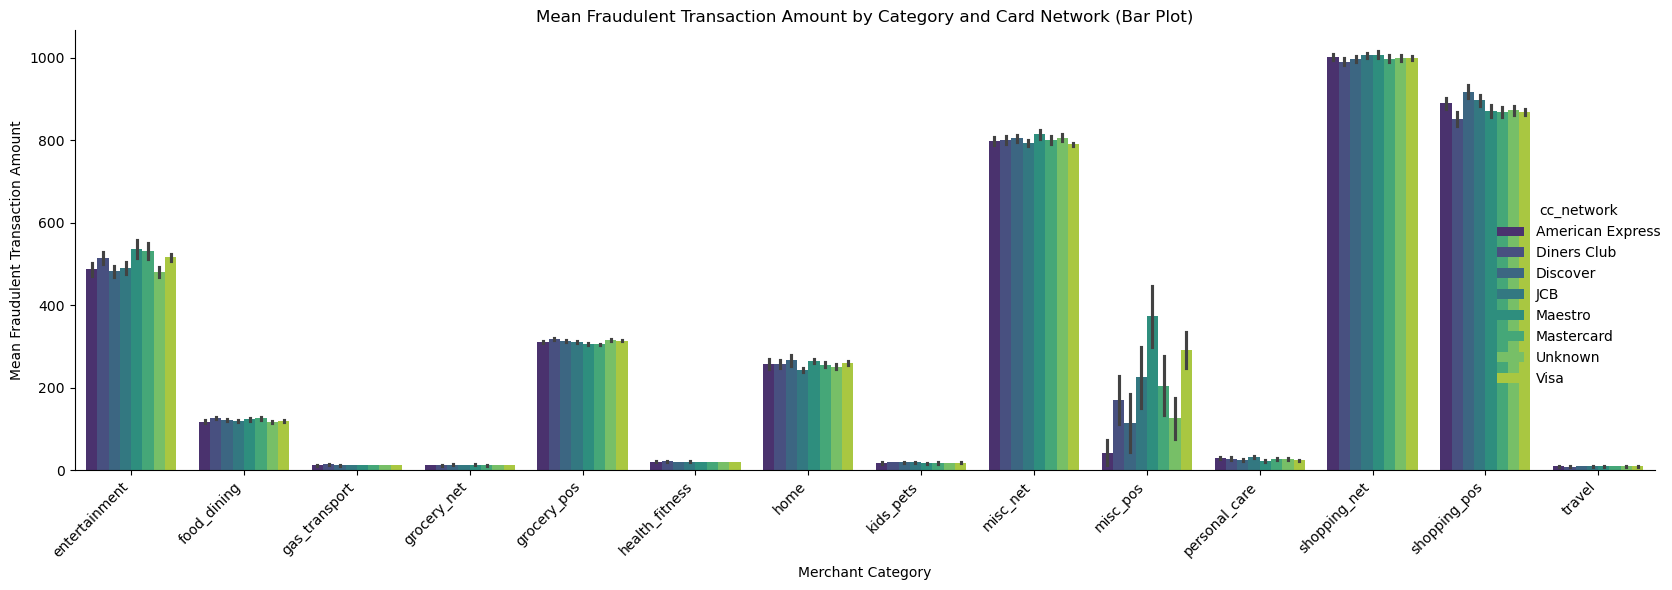

In [112]:
# Set DPI and save path
dpi = 1200
save_path = "../Image/Mean_Fraud_Amount_by_Category_and_CC_Network.png"

# Plotting the interaction
plt.figure(figsize=(18, 9))
sns.catplot(data=fraud_df, x='category', y='amt', hue='cc_network', kind='bar',
            errorbar='se', palette='viridis', height=6, aspect=2.5)
plt.title('Mean Fraudulent Transaction Amount by Category and Card Network (Bar Plot)')
plt.xlabel('Merchant Category')
plt.ylabel('Mean Fraudulent Transaction Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(save_path, dpi=dpi) # Added dpi argument here
plt.show()

#### Highest Mean Fraud Amounts (Overall):
- `shopping_net` (Online Shopping) consistently shows the highest mean fraudulent transaction amounts, often around $1000 across most card networks. This indicates that when fraud occurs in online shopping, it tends to involve large sums.
- `misc_net` (Miscellaneous Online) is also very high, with mean fraudulent amounts consistently around $800.

#### Lowest Mean Fraud Amounts:
- `gas_transport` and `grocery_net` (Online Grocery) consistently have very low mean fraudulent amounts, generally ranging from $11 to $13. This suggests that while fraud might occur in these categories, it typically involves smaller sums.
- `travel` also shows very low mean fraudulent amounts (around $8 - $10), which might be counter-intuitive as travel transactions can be expensive. This could indicate that while there might be many fraudulent travel transactions, their individual values are low, perhaps due to specific types of small-ticket travel fraud.

#### Variability within Categories (Interaction Effect in action):
- For categories like `misc_pos` (Miscellaneous Point-of-Sale), you can see significant variation across card networks. For instance, `American Express` has a mean of nearly $40, while `Maestro` is about $400, and `JCB` is bit over $200. This is a clear example of the interaction effect; the mean fraudulent amount for `misc_pos` depends heavily on the `cc_network` used, and this combination could be "high-risk pairing".
- `entertainment`, `food_dining`, `home`, `health_fitness`, `kids_pets`, `personal_care`, `shopping_pos` show relatively less variation across networks within their respective categories, though minor differences exist. For example, in `entertainment`, values range from approximately $480 to $540, a tighter range than `misc_pos`.


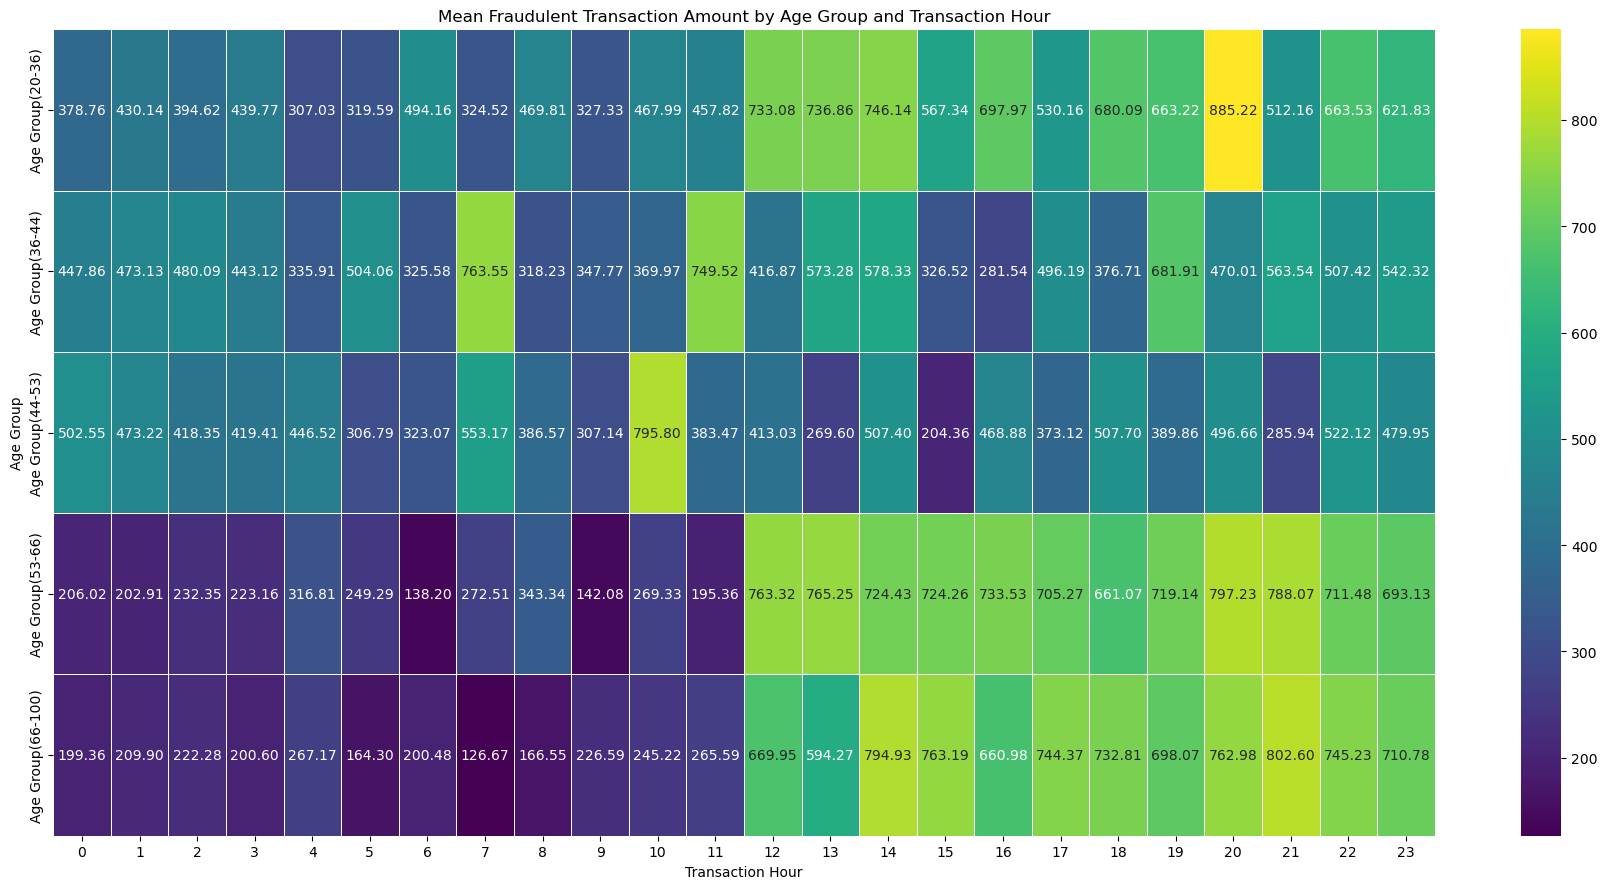

In [113]:
# Set DPI and save path
dpi = 1200
save_path = "../Image/Mean_Fraud_Amount_by_Age_Group_and_Transaction_Hour.png"

# Create a pivot table to get the mean fraudulent amount for each combination
mean_fraud_amount = fraud_df.groupby(['age_group', 'trans_hour'], observed=False)['amt'].mean().unstack()

# Plotting the interaction
plt.figure(figsize=(18, 9))
sns.heatmap(mean_fraud_amount, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Mean Fraudulent Transaction Amount by Age Group and Transaction Hour')
plt.xlabel('Transaction Hour')
plt.ylabel('Age Group')
plt.tight_layout()
plt.savefig(save_path, dpi=dpi)
plt.show()

##### Time of day is a critical factor in the average value of fraudulent transactions.
- Older age groups (Age Group(53-66) and Age Group(66-100)) appear to be targets for very high-value fraud during specific late-night/early-morning hours, even if their daytime fraud amounts are lower.
- Fraud detection systems should incorporate time-of-day specific thresholds and age-group specific rules. For instance, a transaction of $500 might be deemed less suspicious during the middle of the day for a younger age group, but highly suspicious for an older age group late at night.

### New Features

In [114]:
df_train.job.value_counts()

job
Film/video editor             9779
Exhibition designer           9199
Naval architect               8684
Surveyor, land/geomatics      8680
Materials engineer            8270
                              ... 
Information officer              8
Veterinary surgeon               8
Warehouse manager                7
Ship broker                      7
Contracting civil engineer       7
Name: count, Length: 494, dtype: int64

In [115]:
df_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age,industry,cc_network,store_distance,amt_log,city_pop_log,age_group
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0.866025,0.781831,0.62349,37,Airlines & Financial,Mastercard,48.838332,1.786747,8.159375,Age Group(36-44)
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,0.866025,0.781831,0.62349,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001,4.684259,5.010635,Age Group(44-53)
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,0.866025,0.781831,0.62349,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235,5.398660,8.332068,Age Group(53-66)
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,0.866025,0.781831,0.62349,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671,3.828641,7.570443,Age Group(53-66)
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,0.866025,0.781831,0.62349,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592,3.760269,4.605170,Age Group(36-44)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,-1.000000,-0.781831,0.62349,63,"Travel & Entertainment (e.g., American Express...",Diners Club,74.410630,2.806990,5.556828,Age Group(53-66)
1296671,1296671,2020-06-21 12:12:19,6011149206456997,Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,-1.000000,-0.781831,0.62349,45,"Merchandising & Banking (e.g., Discover)",Discover,46.667579,3.964615,4.615121,Age Group(44-53)
1296672,1296672,2020-06-21 12:12:32,3514865930894695,Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,-1.000000,-0.781831,0.62349,57,"Travel & Entertainment (e.g., American Express...",Unknown,61.545493,4.672174,6.802395,Age Group(53-66)
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,-1.000000,-0.781831,0.62349,44,Airlines & Financial,Mastercard,52.585257,4.329417,7.027315,Age Group(36-44)


#### Target Encoding

In [116]:
# for target encoding
new_features = ['cc_num','industry','cc_network','age_group','job', 'state', 'city', 'merchant', 'category', 'zip']

# Target encoding
train, test = te.leakage_free_target_encoding(
    df_train,
    df_test,
    'is_fraud',
    new_features,
    RANDOM_STATE,
    smoothing=100,
    n_splits=5,
)

In [117]:
train, test = te.leakage_free_amount_target_encoding(
    train,
    test,
    'is_fraud',
    'amt',
    ['cc_num','industry','cc_network','age_group','job', 'state', 'city', 'merchant', 'category', 'zip'],
    RANDOM_STATE,
    encoding_type='avg_fraud_amount', # 'avg_fraud_amount' or 'weighted_fraud_rate'
    smoothing=100,
    n_splits=5
)

In [77]:
train.describe()

,Unnamed: 0,trans_date_trans_time,cc_num,amt,lat,long,city_pop,dob,unix_time,merch_lat,...,cc_num_te,industry_te,cc_network_te,age_group_te,job_te,state_te,city_te,merchant_te,category_te,zip_te
count,1.296675e+06,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1296675,1.296675e+06,1.296675e+06,...,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,2019-10-03 12:47:28.070214144,4.171920e+17,7.035104e+01,3.853762e+01,-9.022634e+01,8.882444e+04,1973-10-03 19:02:55.017178512,1.349244e+09,3.853734e+01,...,5.523529e-03,5.788492e-03,5.788467e-03,5.788574e-03,5.699263e-03,5.784359e-03,5.542371e-03,5.789704e-03,5.788565e-03,5.481662e-03
min,0.000000e+00,2019-01-01 00:00:18,6.041621e+10,1.000000e+00,2.002710e+01,-1.656723e+02,2.300000e+01,1924-10-30 00:00:00,1.325376e+09,1.902779e+01,...,7.296237e-14,5.295546e-03,4.734303e-03,4.261305e-03,0.000000e+00,1.577998e-03,2.829990e-15,1.052960e-11,1.445192e-03,7.296237e-14
25%,3.241685e+05,2019-06-03 19:12:22.500000,1.800429e+14,9.650000e+00,3.462050e+01,-9.679800e+01,7.430000e+02,1962-08-13 00:00:00,1.338751e+09,3.473357e+01,...,1.452785e-03,5.476167e-03,5.527223e-03,4.349248e-03,3.052503e-03,5.158302e-03,1.710133e-03,1.668521e-03,2.085390e-03,8.233841e-04
50%,6.483370e+05,2019-10-03 07:35:47,3.521417e+15,4.752000e+01,3.935430e+01,-8.747690e+01,2.456000e+03,1975-11-30 00:00:00,1.349250e+09,3.936568e+01,...,4.890290e-03,5.715702e-03,5.874259e-03,5.752270e-03,5.116959e-03,5.627798e-03,4.725340e-03,3.333333e-03,2.937720e-03,4.453241e-03
75%,9.725055e+05,2020-01-28 15:02:55.500000,4.642255e+15,8.314000e+01,4.194040e+01,-8.015800e+01,2.032800e+04,1987-02-22 00:00:00,1.359385e+09,4.195716e+01,...,6.913890e-03,5.903385e-03,6.279924e-03,7.177444e-03,7.433102e-03,6.603731e-03,7.339449e-03,8.461132e-03,7.174695e-03,7.277138e-03
max,1.296674e+06,2020-06-21 12:13:37,4.992346e+18,2.894890e+04,6.669330e+01,-6.795030e+01,2.906700e+06,2005-01-29 00:00:00,1.371817e+09,6.751027e+01,...,4.979338e-01,7.069993e-03,6.708980e-03,7.589243e-03,4.954311e-01,4.731370e-01,4.979338e-01,2.736953e-02,1.781441e-02,4.979338e-01
std,3.743180e+05,NaN,1.308806e+18,1.603160e+02,5.075808e+00,1.375908e+01,3.019564e+05,NaN,1.284128e+07,5.109788e+00,...,1.164843e-02,3.722081e-04,5.339175e-04,1.320693e-03,7.187072e-03,1.722495e-03,1.109561e-02,5.611908e-03,5.366596e-03,1.215746e-02


In [79]:
train.describe()

,Unnamed: 0,trans_date_trans_time,cc_num,amt,lat,long,city_pop,dob,unix_time,merch_lat,...,cc_num_avg_fraud_amount_te,industry_avg_fraud_amount_te,cc_network_avg_fraud_amount_te,age_group_avg_fraud_amount_te,job_avg_fraud_amount_te,state_avg_fraud_amount_te,city_avg_fraud_amount_te,merchant_avg_fraud_amount_te,category_avg_fraud_amount_te,zip_avg_fraud_amount_te
count,1.296675e+06,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1296675,1.296675e+06,1.296675e+06,...,1296675.0,1296675.0,1296675.0,1296675.0,1296675.0,1296675.0,1296675.0,1296675.0,1296675.0,1296675.0
mean,6.483370e+05,2019-10-03 12:47:28.070214144,4.171920e+17,7.035104e+01,3.853762e+01,-9.022634e+01,8.882444e+04,1973-10-03 19:02:55.017178512,1.349244e+09,3.853734e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000e+00,2019-01-01 00:00:18,6.041621e+10,1.000000e+00,2.002710e+01,-1.656723e+02,2.300000e+01,1924-10-30 00:00:00,1.325376e+09,1.902779e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.241685e+05,2019-06-03 19:12:22.500000,1.800429e+14,9.650000e+00,3.462050e+01,-9.679800e+01,7.430000e+02,1962-08-13 00:00:00,1.338751e+09,3.473357e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,6.483370e+05,2019-10-03 07:35:47,3.521417e+15,4.752000e+01,3.935430e+01,-8.747690e+01,2.456000e+03,1975-11-30 00:00:00,1.349250e+09,3.936568e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,9.725055e+05,2020-01-28 15:02:55.500000,4.642255e+15,8.314000e+01,4.194040e+01,-8.015800e+01,2.032800e+04,1987-02-22 00:00:00,1.359385e+09,4.195716e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.296674e+06,2020-06-21 12:13:37,4.992346e+18,2.894890e+04,6.669330e+01,-6.795030e+01,2.906700e+06,2005-01-29 00:00:00,1.371817e+09,6.751027e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,3.743180e+05,NaN,1.308806e+18,1.603160e+02,5.075808e+00,1.375908e+01,3.019564e+05,NaN,1.284128e+07,5.109788e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train.head()

#### Addtional Features

In [ ]:
df_train.info()

In [ ]:
for col in df_train.select_dtypes(include="category").columns:
    ordered = df_train[col].cat.ordered
    print(f"{col}: Ordered = {ordered}")

In [ ]:
# Sanity check for Features
df_train.shape, df_test.shape

## Save the processed dataframes to new Pickle files

In [ ]:
# save data
df_train.to_pickle('../Data/df_train_processed.pkl')
df_test.to_pickle('../Data/df_test_processed.pkl')
